In [ ]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.api import OLS
from matplotlib.pyplot import subplots
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Read Data Set
df = pd.read_csv('news.csv')

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# Check Nulls
df.isnull().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


In [ ]:
# Count the occurrences of each unique value in the 'label' column
label_counts = df['label'].value_counts()

# Print the counts
print(label_counts)

# Access the counts for 'FAKE' and 'REAL' specifically
fake_count = label_counts.get('FAKE', 0)  # Use .get() to handle potential missing keys
real_count = label_counts.get('REAL', 0)

print(f"Number of FAKE news articles: {fake_count}")
print(f"Number of REAL news articles: {real_count}")

label
REAL    3171
FAKE    3164
Name: count, dtype: int64
Number of FAKE news articles: 3164
Number of REAL news articles: 3171


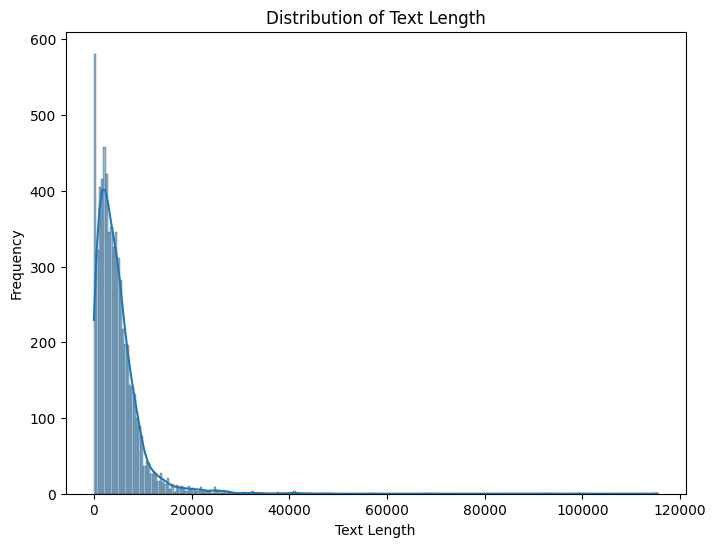

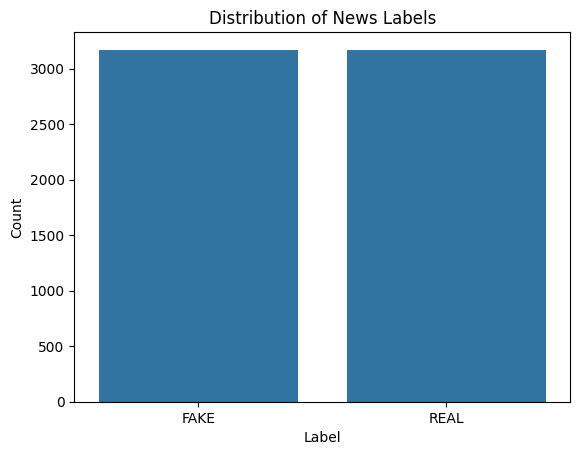

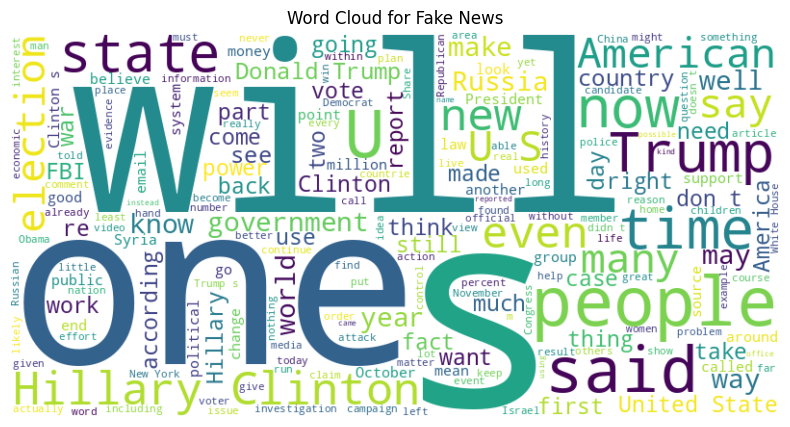

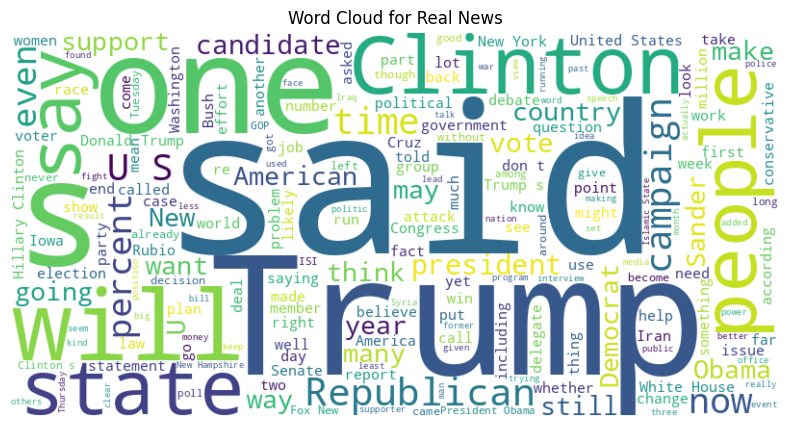

In [ ]:
# Visualizations
df['text_length'] = df['text'].str.len() # Calculate the length of 'text' column and assign to a new 'text_length' column.

plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


sns.countplot(x='label', data=df)
plt.title('Distribution of News Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


# Word Cloud
# Combine all text for each label
fake_text = ' '.join(df[df['label'] == 'FAKE']['text'])
real_text = ' '.join(df[df['label'] == 'REAL']['text'])

# Create word clouds
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(fake_text)
wordcloud_real = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(real_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Fake News')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Real News')
plt.show()

In [ ]:
# Drop the unnecessary index column
df_cleaned = df.drop(columns=['Unnamed: 0'])

# Strip whitespaces from title and text
df_cleaned['title'] = df_cleaned['title'].str.strip()
df_cleaned['text'] = df_cleaned['text'].str.strip()

# Remove rows where title or text is empty after stripping
df_cleaned = df_cleaned[
    (df_cleaned['title'].str.len() > 0) &
    (df_cleaned['text'].str.len() > 0)
]

# Show shape of the cleaned data
print("Cleaned data shape:", df_cleaned.shape)

# Preview cleaned data
print(df_cleaned.head())


Cleaned data shape: (6299, 4)
                                               title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text label  text_length  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE         7518  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE         2646  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL         2543  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE         2660  
4  It's primary day in New York and front-runners...  REAL         1840  


In [ ]:
# Convert 'text' column to lowercase
df_cleaned['text'] = df_cleaned['text'].str.lower()
print("Converted all text to lowercase.")
print(df_cleaned['text'].head(2))


Converted all text to lowercase.
0    daniel greenfield, a shillman journalism fello...
1    google pinterest digg linkedin reddit stumbleu...
Name: text, dtype: object


In [ ]:
df_cleaned.head()

,title,text,label,text_length
0,You Can Smell Hillary’s Fear,"daniel greenfield, a shillman journalism fello...",FAKE,7518
1,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,FAKE,2646
2,Kerry to go to Paris in gesture of sympathy,u.s. secretary of state john f. kerry said mon...,REAL,2543
3,Bernie supporters on Twitter erupt in anger ag...,"— kaydee king (@kaydeeking) november 9, 2016 t...",FAKE,2660
4,The Battle of New York: Why This Primary Matters,it's primary day in new york and front-runners...,REAL,1840


In [ ]:
# Remove punctuation
df_cleaned['text'] = df_cleaned['text'].apply(lambda x: re.sub(f"[{re.escape(string.punctuation)}]", "", x))
print("Removed punctuation from text.")
print(df_cleaned['text'].head(2))


Removed punctuation from text.
0    daniel greenfield a shillman journalism fellow...
1    google pinterest digg linkedin reddit stumbleu...
Name: text, dtype: object


In [ ]:
# Remove URLs and numeric digits
df_cleaned['text'] = df_cleaned['text'].apply(lambda x: re.sub(r"http\S+|www\S+|\d+", "", x))
print("Removed URLs and numbers from text.")
print(df_cleaned['text'].head(2))


Removed URLs and numbers from text.
0    daniel greenfield a shillman journalism fellow...
1    google pinterest digg linkedin reddit stumbleu...
Name: text, dtype: object


In [ ]:
# Download stopwords
nltk.download('stopwords')

tokenizer = TreebankWordTokenizer()
stop_words = set(stopwords.words('english'))

# Remove stopwords using Treebank tokenizer
df_cleaned['text'] = df_cleaned['text'].apply(
    lambda x: ' '.join([word for word in tokenizer.tokenize(x) if word.lower() not in stop_words])
)

print("Successfully removed stopwords using Treebank tokenizer.")
print(df_cleaned['text'].head(2))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Successfully removed stopwords using Treebank tokenizer.
0    daniel greenfield shillman journalism fellow f...
1    google pinterest digg linkedin reddit stumbleu...
Name: text, dtype: object


In [ ]:
df_cleaned.head()

,title,text,label,text_length
0,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow f...,FAKE,7518
1,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,FAKE,2646
2,Kerry to go to Paris in gesture of sympathy,us secretary state john f kerry said monday st...,REAL,2543
3,Bernie supporters on Twitter erupt in anger ag...,— kaydee king kaydeeking november lesson tonig...,FAKE,2660
4,The Battle of New York: Why This Primary Matters,primary day new york frontrunners hillary clin...,REAL,1840


In [ ]:
tokenizer = TreebankWordTokenizer()

# Tokenize text using Treebank tokenizer
df_cleaned['text'] = df_cleaned['text'].apply(lambda x: tokenizer.tokenize(x))
print("Tokenized the text using TreebankWordTokenizer.")
print(df_cleaned['text'].head(2))


Tokenized the text using TreebankWordTokenizer.
0    [daniel, greenfield, shillman, journalism, fel...
1    [google, pinterest, digg, linkedin, reddit, st...
Name: text, dtype: object


In [ ]:
df_cleaned.head()

,title,text,label,text_length
0,You Can Smell Hillary’s Fear,"[daniel, greenfield, shillman, journalism, fel...",FAKE,7518
1,Watch The Exact Moment Paul Ryan Committed Pol...,"[google, pinterest, digg, linkedin, reddit, st...",FAKE,2646
2,Kerry to go to Paris in gesture of sympathy,"[us, secretary, state, john, f, kerry, said, m...",REAL,2543
3,Bernie supporters on Twitter erupt in anger ag...,"[—, kaydee, king, kaydeeking, november, lesson...",FAKE,2660
4,The Battle of New York: Why This Primary Matters,"[primary, day, new, york, frontrunners, hillar...",REAL,1840


In [ ]:
stemmer = PorterStemmer()

# Apply stemming
df_cleaned['text'] = df_cleaned['text'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
print("Applied stemming to tokens.")
print(df_cleaned['text'].head(2))


Applied stemming to tokens.
0    [daniel, greenfield, shillman, journal, fellow...
1    [googl, pinterest, digg, linkedin, reddit, stu...
Name: text, dtype: object


In [ ]:
df_cleaned.head()

,title,text,label,text_length
0,You Can Smell Hillary’s Fear,"[daniel, greenfield, shillman, journal, fellow...",FAKE,7518
1,Watch The Exact Moment Paul Ryan Committed Pol...,"[googl, pinterest, digg, linkedin, reddit, stu...",FAKE,2646
2,Kerry to go to Paris in gesture of sympathy,"[us, secretari, state, john, f, kerri, said, m...",REAL,2543
3,Bernie supporters on Twitter erupt in anger ag...,"[—, kayde, king, kaydeek, novemb, lesson, toni...",FAKE,2660
4,The Battle of New York: Why This Primary Matters,"[primari, day, new, york, frontrunn, hillari, ...",REAL,1840


In [ ]:
# Join stemmed tokens back into strings
df_cleaned['text'] = df_cleaned['text'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)


In [ ]:
# Combine 'title' and 'text' into a single column
df_cleaned['combined_text'] = df_cleaned['title'] + " " + df_cleaned['text']

In [ ]:
# Encode labels (FAKE → 0, REAL → 1)
label_encoder = LabelEncoder()
df_cleaned['label_encoded'] = label_encoder.fit_transform(df_cleaned['label'])

In [ ]:
df_cleaned.head()

,title,text,label,text_length,combined_text,label_encoded
0,You Can Smell Hillary’s Fear,daniel greenfield shillman journal fellow free...,FAKE,7518,You Can Smell Hillary’s Fear daniel greenfield...,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,googl pinterest digg linkedin reddit stumbleup...,FAKE,2646,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,Kerry to go to Paris in gesture of sympathy,us secretari state john f kerri said monday st...,REAL,2543,Kerry to go to Paris in gesture of sympathy us...,1
3,Bernie supporters on Twitter erupt in anger ag...,— kayde king kaydeek novemb lesson tonight dem...,FAKE,2660,Bernie supporters on Twitter erupt in anger ag...,0
4,The Battle of New York: Why This Primary Matters,primari day new york frontrunn hillari clinton...,REAL,1840,The Battle of New York: Why This Primary Matte...,1


In [ ]:
# TF-IDF(Term Frequency-Inverse Document Frequency) Vectorization (convert text to numbers)
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, max_features=5000)
X = vectorizer.fit_transform(df_cleaned['combined_text'])
y = df_cleaned['label_encoded']

In [ ]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("TF-IDF applied and data split completed.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

TF-IDF applied and data split completed.
X_train shape: (5039, 5000)
X_test shape: (1260, 5000)


Logistic Regression Accuracy: 92.46 %

 Classification Report:
              precision    recall  f1-score   support

        FAKE       0.92      0.93      0.92       625
        REAL       0.93      0.92      0.92       635

    accuracy                           0.92      1260
   macro avg       0.92      0.92      0.92      1260
weighted avg       0.92      0.92      0.92      1260



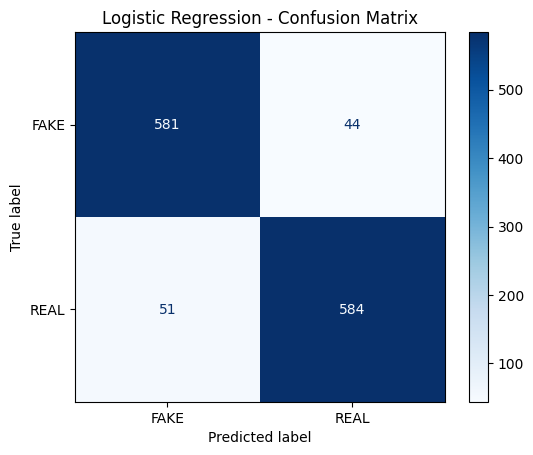

In [ ]:
#  Logistic Regression Model

# Train the model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Predict on test data
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
print("Logistic Regression Accuracy:", round(logreg_accuracy * 100, 2), "%")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


Naive Bayes Accuracy: 88.02 %

 Classification Report:
              precision    recall  f1-score   support

        FAKE       0.87      0.89      0.88       625
        REAL       0.89      0.87      0.88       635

    accuracy                           0.88      1260
   macro avg       0.88      0.88      0.88      1260
weighted avg       0.88      0.88      0.88      1260



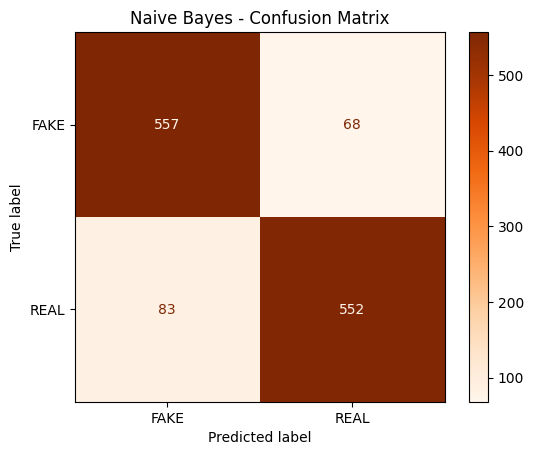

In [ ]:
#  Multinomial Naive Bayes Model

# Train the model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on test data
y_pred_nb = nb_model.predict(X_test)

# Evaluate
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", round(nb_accuracy * 100, 2), "%")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Naive Bayes - Confusion Matrix")
plt.show()


 SVM Accuracy: 93.17 %

 Classification Report:
              precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93       625
        REAL       0.94      0.92      0.93       635

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260



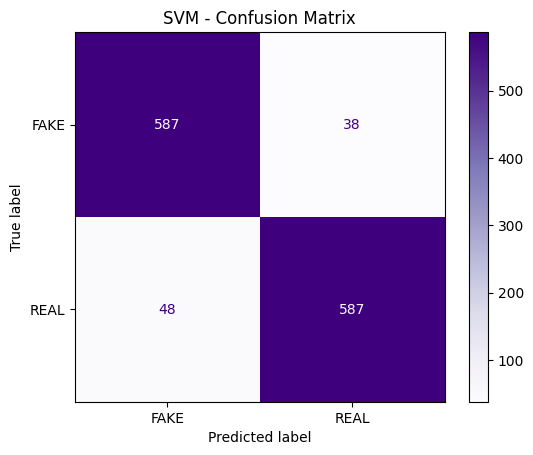

In [ ]:
#  Support Vector Machine (SVM)

# Train the model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm_model.predict(X_test)

# Evaluate
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(" SVM Accuracy:", round(svm_accuracy * 100, 2), "%")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Purples)
plt.title("SVM - Confusion Matrix")
plt.show()


 Decision Tree Accuracy: 77.22 %

 Classification Report:
              precision    recall  f1-score   support

        FAKE       0.77      0.76      0.77       625
        REAL       0.77      0.78      0.78       635

    accuracy                           0.77      1260
   macro avg       0.77      0.77      0.77      1260
weighted avg       0.77      0.77      0.77      1260



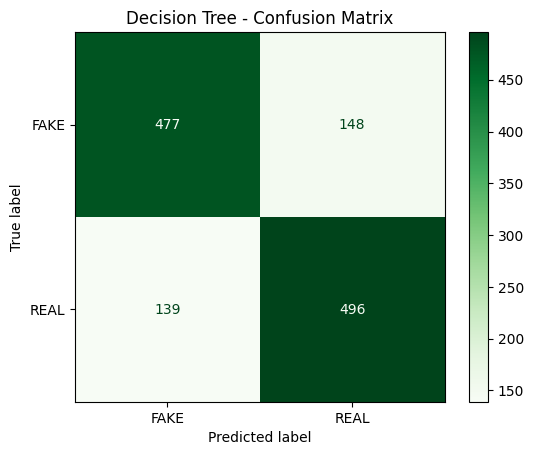

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


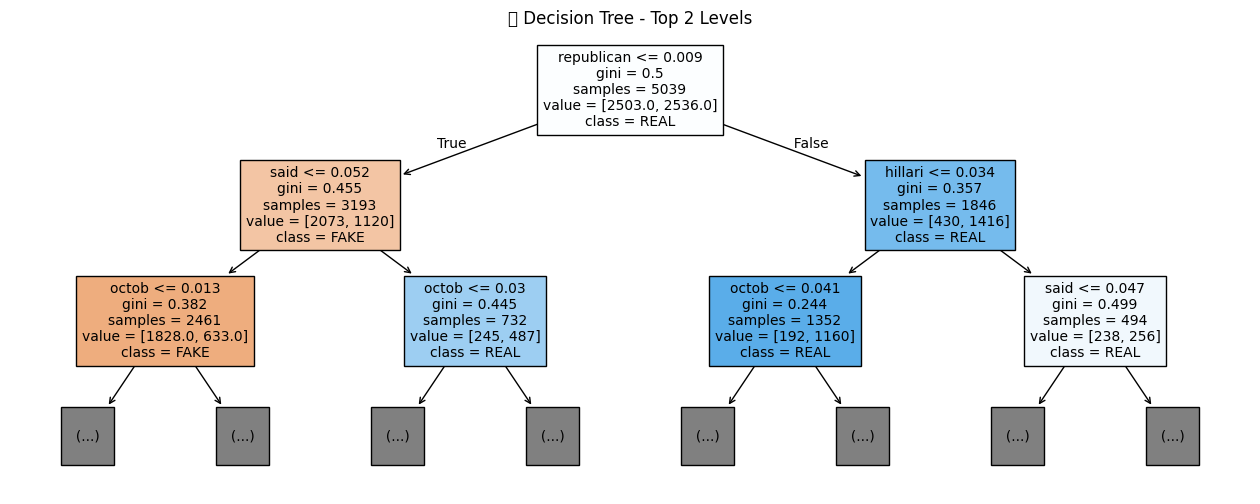

In [ ]:
#  Decision Tree Classifier

# Train the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on test data
y_pred_dt = dt_model.predict(X_test)

# Evaluate
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(" Decision Tree Accuracy:", round(dt_accuracy * 100, 2), "%")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# Optional: Visualize top levels of the tree
plt.figure(figsize=(16, 6))
plot_tree(dt_model, max_depth=2, feature_names=vectorizer.get_feature_names_out(),
          class_names=label_encoder.classes_, filled=True, fontsize=10)
plt.title("📊 Decision Tree - Top 2 Levels")
plt.show()


 Random Forest Accuracy: 91.51 %

 Classification Report:
              precision    recall  f1-score   support

        FAKE       0.90      0.93      0.92       625
        REAL       0.93      0.90      0.91       635

    accuracy                           0.92      1260
   macro avg       0.92      0.92      0.92      1260
weighted avg       0.92      0.92      0.92      1260



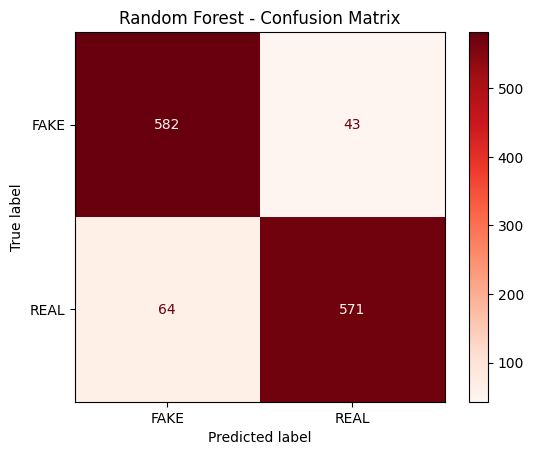

In [ ]:

#  Random Forest Classifier

# Train the model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(" Random Forest Accuracy:", round(rf_accuracy * 100, 2), "%")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title("Random Forest - Confusion Matrix")
plt.show()


 Model Accuracy Comparison:
                        Accuracy (%)
Support Vector Machine         93.17
Logistic Regression            92.46
Random Forest                  91.51
Naive Bayes                    88.02
Decision Tree                  77.22


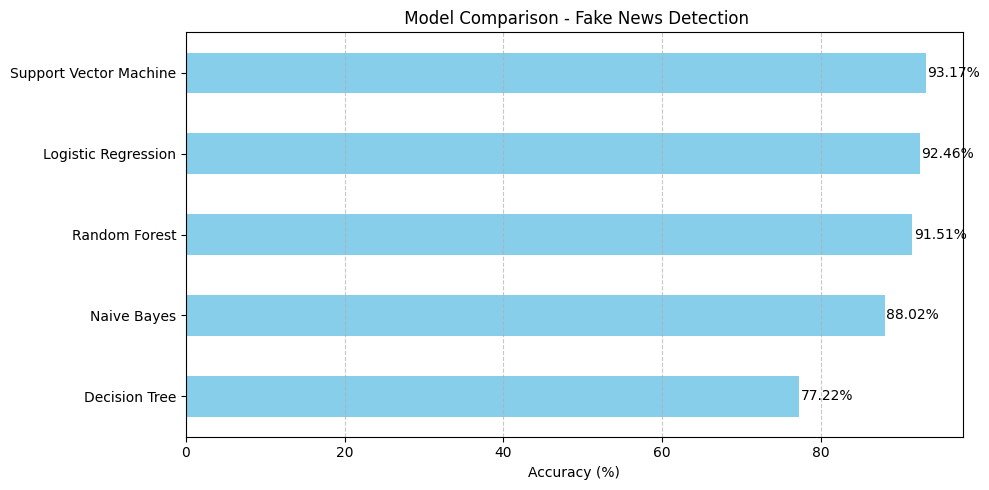

In [ ]:
#  Accuracy Comparison Table

# Store the accuracy results from earlier models
accuracy_scores = {
    "Logistic Regression": round(logreg_accuracy * 100, 2),
    "Naive Bayes": round(nb_accuracy * 100, 2),
    "Support Vector Machine": round(svm_accuracy * 100, 2),
    "Decision Tree": round(dt_accuracy * 100, 2),
    "Random Forest": round(rf_accuracy * 100, 2)
}

# Create DataFrame
accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index', columns=["Accuracy (%)"])
accuracy_df = accuracy_df.sort_values(by="Accuracy (%)", ascending=False)

# Display the table
print(" Model Accuracy Comparison:")
print(accuracy_df)


#  Bar Chart of Model Accuracy


accuracy_df.plot(kind='barh', legend=False, color='skyblue', figsize=(10, 5))
plt.xlabel("Accuracy (%)")
plt.title(" Model Comparison - Fake News Detection")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Highest accuracy at the top

# Add text labels for each bar
for i, v in enumerate(accuracy_df["Accuracy (%)"]):
    plt.text(v + 0.2, i, f"{v}%", va='center')

plt.tight_layout()
plt.show()


## Hyperparameter Tuning

 Best Parameters (Logistic Regression): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
 Accuracy after tuning: 93.25 %
              precision    recall  f1-score   support

        FAKE       0.93      0.93      0.93       625
        REAL       0.94      0.93      0.93       635

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260



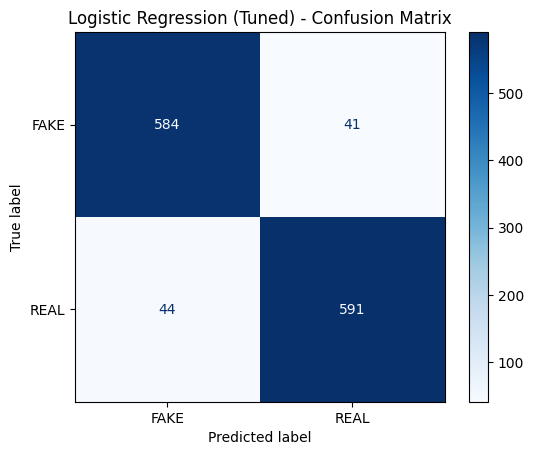

In [ ]:
#  Logistic Regression - Grid Search

# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Only solver that supports both l1 and l2
}

# Set up grid search
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Evaluate best model
best_lr = grid_lr.best_estimator_
y_pred_lr_tuned = best_lr.predict(X_test)

print(" Best Parameters (Logistic Regression):", grid_lr.best_params_)
print(" Accuracy after tuning:", round(accuracy_score(y_test, y_pred_lr_tuned) * 100, 2), "%")
print(classification_report(y_test, y_pred_lr_tuned, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_lr_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Logistic Regression (Tuned) - Confusion Matrix")
plt.show()


 Best Parameters (Naive Bayes): {'alpha': 0.01}
 Accuracy after tuning: 88.02 %
              precision    recall  f1-score   support

        FAKE       0.87      0.90      0.88       625
        REAL       0.90      0.86      0.88       635

    accuracy                           0.88      1260
   macro avg       0.88      0.88      0.88      1260
weighted avg       0.88      0.88      0.88      1260



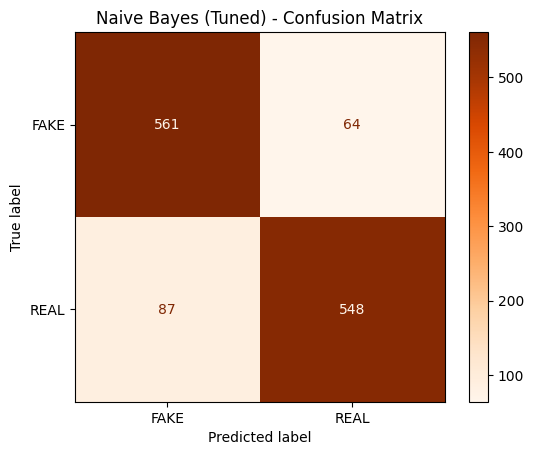

In [ ]:
#  Naive Bayes - Grid Search

# Define parameter grid
param_grid_nb = {
    'alpha': [0.01, 0.1, 0.5, 1, 5, 10]
}

# Set up grid search
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train, y_train)

# Evaluate best model
best_nb = grid_nb.best_estimator_
y_pred_nb_tuned = best_nb.predict(X_test)

print(" Best Parameters (Naive Bayes):", grid_nb.best_params_)
print(" Accuracy after tuning:", round(accuracy_score(y_test, y_pred_nb_tuned) * 100, 2), "%")
print(classification_report(y_test, y_pred_nb_tuned, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_nb_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Oranges')
plt.title("Naive Bayes (Tuned) - Confusion Matrix")
plt.show()


 Best Parameters (SVM): {'C': 1, 'loss': 'squared_hinge', 'max_iter': 1000}
 Accuracy after tuning: 93.17 %
              precision    recall  f1-score   support

        FAKE       0.92      0.94      0.93       625
        REAL       0.94      0.92      0.93       635

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260



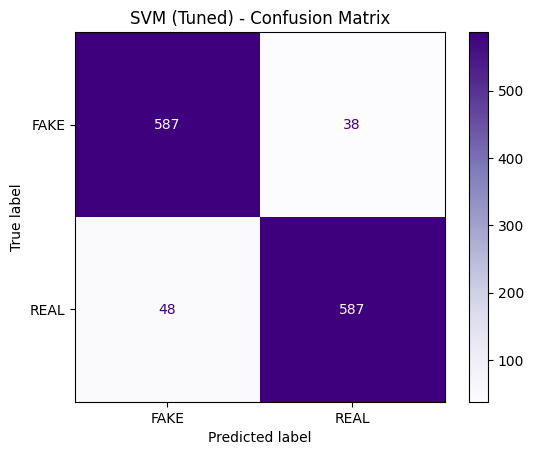

In [ ]:
#  Support Vector Machine - Grid Search

# Define parameter grid
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 2000]
}

# Set up grid search
grid_svm = GridSearchCV(LinearSVC(), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Evaluate best model
best_svm = grid_svm.best_estimator_
y_pred_svm_tuned = best_svm.predict(X_test)

print(" Best Parameters (SVM):", grid_svm.best_params_)
print(" Accuracy after tuning:", round(accuracy_score(y_test, y_pred_svm_tuned) * 100, 2), "%")
print(classification_report(y_test, y_pred_svm_tuned, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title("SVM (Tuned) - Confusion Matrix")
plt.show()


 Best Parameters (Random Forest): {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
 Accuracy after tuning: 92.46 %
              precision    recall  f1-score   support

        FAKE       0.92      0.93      0.92       625
        REAL       0.93      0.92      0.92       635

    accuracy                           0.92      1260
   macro avg       0.92      0.92      0.92      1260
weighted avg       0.92      0.92      0.92      1260



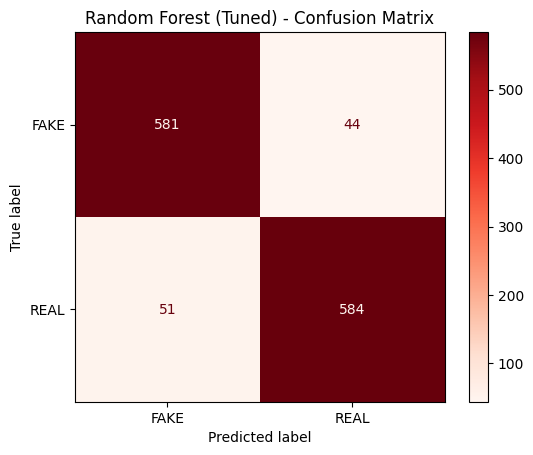

In [ ]:
#  Random Forest - Grid Search

# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

# Set up grid search
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Evaluate best model
best_rf = grid_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

rf_accuracy_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(" Best Parameters (Random Forest):", grid_rf.best_params_)
print(" Accuracy after tuning:", round(rf_accuracy_tuned * 100, 2), "%")
print(classification_report(y_test, y_pred_rf_tuned, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Reds')
plt.title("Random Forest (Tuned) - Confusion Matrix")
plt.show()


 Best Parameters (Decision Tree): {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5}
 Accuracy after tuning: 79.68 %
              precision    recall  f1-score   support

        FAKE       0.78      0.82      0.80       625
        REAL       0.81      0.77      0.79       635

    accuracy                           0.80      1260
   macro avg       0.80      0.80      0.80      1260
weighted avg       0.80      0.80      0.80      1260



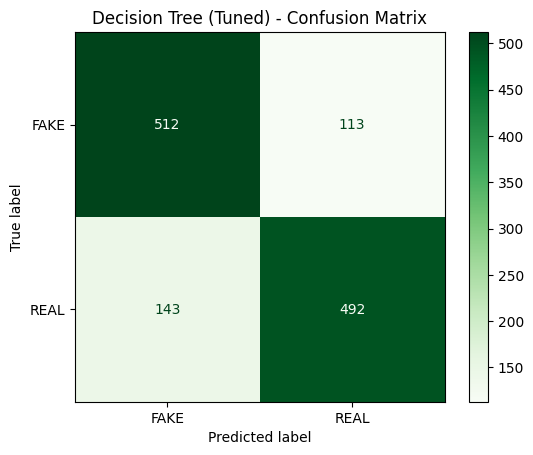

In [ ]:
#  Decision Tree - Grid Search

# Define parameter grid
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Set up grid search
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)

# Evaluate best model
best_dt = grid_dt.best_estimator_
y_pred_dt_tuned = best_dt.predict(X_test)

print(" Best Parameters (Decision Tree):", grid_dt.best_params_)
print(" Accuracy after tuning:", round(accuracy_score(y_test, y_pred_dt_tuned) * 100, 2), "%")
print(classification_report(y_test, y_pred_dt_tuned, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_dt_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Greens')
plt.title("Decision Tree (Tuned) - Confusion Matrix")
plt.show()


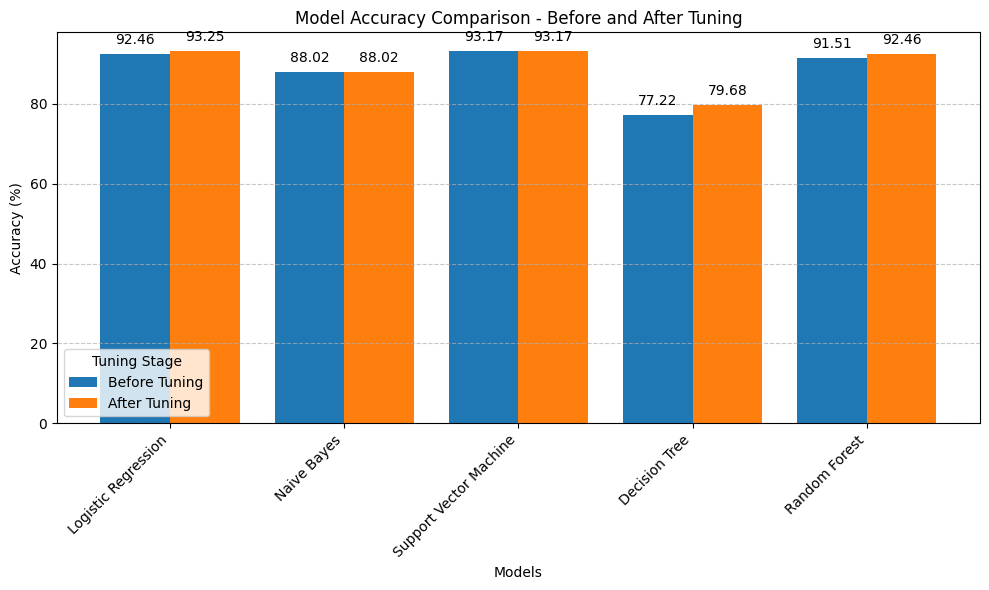

In [ ]:
# Accuracy scores before and after tuning (replace with your actual values)
accuracy_before = {
    "Logistic Regression": 92.46,
    "Naive Bayes": 88.02,
    "Support Vector Machine": 93.17,
    "Decision Tree": 77.22,
    "Random Forest": 91.51
}
accuracy_after = {
    "Logistic Regression": 93.25,
    "Naive Bayes": 88.02,
    "Support Vector Machine": 93.17,
    "Decision Tree": 79.68,
    "Random Forest": 92.46
}


# Create dataframes
accuracy_before_df = pd.DataFrame.from_dict(accuracy_before, orient='index', columns=['Accuracy (%)'])
accuracy_after_df = pd.DataFrame.from_dict(accuracy_after, orient='index', columns=['Accuracy (%)'])

# Combine into a single dataframe for plotting
accuracy_df = pd.concat([accuracy_before_df, accuracy_after_df], axis=1)
accuracy_df.columns = ['Before Tuning', 'After Tuning']

# Plotting the bar graph with labels
ax = accuracy_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title("Model Accuracy Comparison - Before and After Tuning")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Tuning Stage")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations to the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
# Preprocessing function
def preprocess_input(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"http\S+|www\S+|\d+", "", text)
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

# INPUT: Get title and content from user
input_title = input("\nEnter news title:\n")
input_content = input("\nEnter news content:\n")

# Combine and preprocess just like training
news_combined = input_title + " " + input_content
news_cleaned = preprocess_input(news_combined)
news_vector = vectorizer.transform([news_cleaned])

# Run predictions
print("\n Model Predictions:")

lr_result = best_lr.predict(news_vector)[0]
print("LR Prediction:", "Real News" if lr_result == 1 else "Fake News")

nb_result = best_nb.predict(news_vector)[0]
print("NB Prediction:", "Real News" if nb_result == 1 else "Fake News")

svm_result = best_svm.predict(news_vector)[0]
print("SVM Prediction:", "Real News" if svm_result == 1 else "Fake News")

dt_result = best_dt.predict(news_vector)[0]
print("DT Prediction:", "Real News" if dt_result == 1 else "Fake News")

rf_result = best_rf.predict(news_vector)[0]
print("RF Prediction:", "Real News" if rf_result == 1 else "Fake News")



Enter news title:
Iran reportedly makes new push for uranium concessions in nuclear talks

Enter news content:
Iranian negotiators reportedly have made a last-ditch push for more concessions from the U.S. and five other world powers as talks on the fate of Iran's nuclear program come down to the final days before a crucial deadline.  The New York Times reported late Sunday that Tehran had backed away from a tentative promise to ship a large portion of its uranium stockpile to Russia, where it could not be used as part of any future weapons program. Western officials insisted to the paper that the uranium did not have to be sent overseas, but could be disposed of in other ways.  The new twist in the talks comes just two days before the deadline for both sides to agree on a framework for a permanent deal. The final deadline for a permanent deal would not arrive until the end of June.  However, if Iran insists on keeping its uranium in the country, it would undermine a key argument made 